# Logistic Regression Model

## Data Import And Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf
from sklearn.preprocessing import StandardScaler

C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv',
               '../../data/cleaned/utah_2017_bird.csv']

test_files = ['../../data/cleaned/utah_2018_vineyard.csv', 
               '../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']
x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 0
test_index = 1

In [3]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


In [4]:
test_dfs[test_index].head()

,Time America/Boise UTC-06:00,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,4/11/2018 10:30,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6
1,4/11/2018 10:45,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6
2,4/11/2018 11:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7
3,4/11/2018 11:15,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7
4,4/11/2018 11:30,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7


In [5]:
train_dfs[train_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000
mean,18.488235,1933.564575,-116.806951,8.633415,58.129348,87.056980,8.179008,0.979511
std,6.134464,151.800551,8.973830,0.147231,54.622278,13.793755,1.278416,0.731423
min,5.630000,3.000000,-153.700000,7.930000,0.660000,62.800000,5.170000,0.000000
25%,12.700000,1848.000000,-120.800000,8.530000,29.850000,80.000000,7.260000,0.500000
50%,20.320000,1939.000000,-115.700000,8.650000,42.140000,83.200000,8.080000,0.900000
75%,23.630000,2070.000000,-112.100000,8.700000,65.795000,88.900000,9.250000,1.200000
max,28.570000,2164.000000,-76.500000,9.230000,636.700000,209.700000,16.170000,16.100000


In [6]:
test_dfs[test_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000
mean,19.131184,1990.294607,-196.624329,8.922357,63.929067,90.057202,8.309566,1.459773
std,5.045367,230.743946,27.769024,0.357733,70.885989,17.627283,1.486747,1.311960
min,0.000000,0.000000,-284.000000,0.000000,-0.880000,0.000000,0.000000,-0.400000
25%,15.480000,1869.000000,-216.950000,8.730000,33.750000,79.100000,7.280000,0.600000
50%,20.190000,1958.000000,-192.000000,8.920000,48.380000,85.300000,8.010000,1.000000
75%,23.070000,2149.000000,-179.500000,9.100000,68.275000,95.300000,9.240000,1.700000
max,28.600000,2417.000000,0.000000,10.100000,1248.920000,245.500000,19.590000,21.100000


## Use Datetime Index

In [7]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [8]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [9]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


## Import And Clean Weather Data

In [10]:
weather = pd.read_csv('../../data/cleaned/daily_weather_metric_2017_2018.csv')
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DAPR,EVAP,MDPR,MNPN,...,TMAX,TMIN,TOBS,WESD,WESF,WT01,WT03,WT04,WT05,WT11
0,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/1/2017,NaN,NaN,NaN,NaN,...,18.9,7.2,13.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/2/2017,NaN,NaN,NaN,NaN,...,19.4,7.8,17.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/3/2017,NaN,NaN,NaN,NaN,...,21.7,4.4,21.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/4/2017,NaN,NaN,NaN,NaN,...,26.7,6.7,26.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/5/2017,NaN,NaN,NaN,NaN,...,31.7,8.9,30.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Find out how much of the data is missing for each column.
drop_columns = []
missing_threshold = .05
for column in weather.columns:
    number_null = np.sum(weather[column].isnull())
    column_length = len(weather[column])
    should_drop_column = (number_null / column_length) > missing_threshold
    print('{} percent null: {:.1f}%'.format(column, (number_null / column_length) * 100))
    if should_drop_column:
        drop_columns.append(column)
print('dropping columns: {}'.format(drop_columns))
weather = weather.drop(drop_columns, axis=1)

STATION percent null: 0.0%
NAME percent null: 0.0%
LATITUDE percent null: 0.0%
LONGITUDE percent null: 0.0%
ELEVATION percent null: 0.0%
DATE percent null: 0.0%
DAPR percent null: 99.7%
EVAP percent null: 50.6%
MDPR percent null: 99.7%
MNPN percent null: 50.9%
MXPN percent null: 50.9%
PRCP percent null: 0.9%
SNOW percent null: 0.5%
SNWD percent null: 0.5%
TAVG percent null: 100.0%
TMAX percent null: 0.2%
TMIN percent null: 0.0%
TOBS percent null: 0.5%
WESD percent null: 100.0%
WESF percent null: 100.0%
WT01 percent null: 100.0%
WT03 percent null: 99.5%
WT04 percent null: 100.0%
WT05 percent null: 100.0%
WT11 percent null: 100.0%
dropping columns: ['DAPR', 'EVAP', 'MDPR', 'MNPN', 'MXPN', 'TAVG', 'WESD', 'WESF', 'WT01', 'WT03', 'WT04', 'WT05', 'WT11']


In [12]:
# Drop the columns we will not be using.
weather = weather.drop(columns=['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION', 'TOBS'])


In [13]:
weather['DATE'] = pd.to_datetime(weather['DATE'])
# Set a datetime index for convenience
weather['timestamp'] = weather['DATE']
weather = weather.set_index('timestamp')
weather.dtypes

DATE    datetime64[ns]
PRCP           float64
SNOW           float64
SNWD           float64
TMAX           float64
TMIN           float64
dtype: object

In [14]:
total = 0.0
start_date = weather['DATE'][0]
# Year to date preciptation
weather['YTD PRCP'] = weather['DATE'].apply(lambda x: weather['PRCP'][start_date:x.date()].sum())
# precpitation of the last 24H
weather['24H PRCP'] = weather['DATE'].apply(lambda x: weather['PRCP'][x.date()-pd.Timedelta(24, unit='h'):x.date()].sum())
weather['48H PRCP'] = weather['DATE'].apply(lambda x: weather['PRCP'][x.date()-pd.Timedelta(48, unit='h'):x.date()].sum())

In [15]:
weather['DATE'] = weather['DATE'].apply(lambda x: x.date())

In [16]:
# Test some date comparison logic
print(train_dfs[train_index]['datetime'][0].date())
print(weather['DATE'][0])
print(train_dfs[train_index]['datetime'][0].date() == weather['DATE'][0])
print()
print(train_dfs[train_index]['datetime'][0].date())
print(weather['DATE'][4])
print(train_dfs[train_index]['datetime'][0].date() == weather['DATE'][4])


2017-05-05
2017-05-01
False

2017-05-05
2017-05-05
True


In [17]:
# Test some indexing logic
weather[weather['DATE'] == train_dfs[train_index]['datetime'][2].date()]['PRCP'].values[0]

0.0

In [18]:
count = 0
total = len(train_dfs + test_dfs)
for df in train_dfs + test_dfs:
    count += 1
    print("starting dataframe {}/{}".format(count, total))
    for column in weather.drop(columns='DATE').columns:
        print("adding series for column:", column)
        values = []
        old_datetime = None
        value = None
        for datetime in df['datetime']:
            datetime = datetime.date()
            if datetime != old_datetime:
                old_datetime = datetime
                value = weather[weather['DATE'] == datetime][column]
            values.append(value.values[0] if len(value.values) > 0 else np.nan)
        df[column] = values

starting dataframe 1/6
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
adding series for column: YTD PRCP
adding series for column: 24H PRCP
adding series for column: 48H PRCP
starting dataframe 2/6
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
adding series for column: YTD PRCP
adding series for column: 24H PRCP
adding series for column: 48H PRCP
starting dataframe 3/6
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
adding series for column: YTD PRCP
adding series for column: 24H PRCP
adding series for column: 48H PRCP
starting dataframe 4/6
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
addi

### Verify weather values copied over correctly

In [19]:
train_dfs[train_index].head(10)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,YTD PRCP,24H PRCP,48H PRCP
timestamp,,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,0.0,0.0,0.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,0.0,0.0,0.0
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,0.0,0.0,0.0
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,0.0,0.0,0.0
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,0.0,0.0,0.0
2017-05-05 01:15:00,14.92,1850,-100.1,8.36,16.43,89.8,9.02,0.4,2017-05-05 01:15:00,0.0,0.0,0.0,31.7,8.9,0.0,0.0,0.0
2017-05-05 01:30:00,14.90,1851,-100.1,8.36,16.35,89.7,9.01,0.4,2017-05-05 01:30:00,0.0,0.0,0.0,31.7,8.9,0.0,0.0,0.0
2017-05-05 01:45:00,14.88,1852,-100.0,8.36,16.40,89.6,9.00,0.4,2017-05-05 01:45:00,0.0,0.0,0.0,31.7,8.9,0.0,0.0,0.0
2017-05-05 02:00:00,14.84,1850,-99.9,8.36,16.82,89.4,8.99,0.4,2017-05-05 02:00:00,0.0,0.0,0.0,31.7,8.9,0.0,0.0,0.0


In [20]:
weather.head(10)

,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,YTD PRCP,24H PRCP,48H PRCP
timestamp,,,,,,,,,
2017-05-01,2017-05-01,0.0,0.0,0.0,18.9,7.2,0.0,0.0,0.0
2017-05-02,2017-05-02,0.0,0.0,0.0,19.4,7.8,0.0,0.0,0.0
2017-05-03,2017-05-03,0.0,0.0,0.0,21.7,4.4,0.0,0.0,0.0
2017-05-04,2017-05-04,0.0,0.0,0.0,26.7,6.7,0.0,0.0,0.0
2017-05-05,2017-05-05,0.0,0.0,0.0,31.7,8.9,0.0,0.0,0.0
2017-05-06,2017-05-06,1.8,0.0,0.0,30.6,15.0,1.8,1.8,1.8
2017-05-07,2017-05-07,0.0,0.0,0.0,27.2,18.9,1.8,1.8,1.8
2017-05-08,2017-05-08,0.0,0.0,0.0,25.6,12.2,1.8,0.0,1.8
2017-05-09,2017-05-09,0.0,0.0,0.0,25.6,9.4,1.8,0.0,0.0


In [21]:
test_dfs[test_index].head(60)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,YTD PRCP,24H PRCP,48H PRCP
timestamp,,,,,,,,,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00,0.0,0.0,0.0,25.0,10.0,231.6,0.0,0.0
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00,0.0,0.0,0.0,25.0,10.0,231.6,0.0,0.0
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00,0.0,0.0,0.0,25.0,10.0,231.6,0.0,0.0
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00,0.0,0.0,0.0,25.0,10.0,231.6,0.0,0.0
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00,0.0,0.0,0.0,25.0,10.0,231.6,0.0,0.0
2018-04-11 11:45:00,11.69,1783,-143.9,8.16,44.56,88.0,9.49,0.8,2018-04-11 11:45:00,0.0,0.0,0.0,25.0,10.0,231.6,0.0,0.0
2018-04-11 12:00:00,11.67,1782,-144.1,8.16,45.77,88.0,9.50,0.7,2018-04-11 12:00:00,0.0,0.0,0.0,25.0,10.0,231.6,0.0,0.0
2018-04-11 12:15:00,11.74,1783,-144.6,8.17,45.20,88.8,9.58,0.7,2018-04-11 12:15:00,0.0,0.0,0.0,25.0,10.0,231.6,0.0,0.0
2018-04-11 12:30:00,11.68,1783,-144.5,8.17,45.49,88.0,9.50,0.6,2018-04-11 12:30:00,0.0,0.0,0.0,25.0,10.0,231.6,0.0,0.0


In [22]:
start = test_dfs[test_index]['datetime'][0].date()
end = test_dfs[test_index]['datetime'][60].date()
weather[start:end]

,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,YTD PRCP,24H PRCP,48H PRCP
timestamp,,,,,,,,,
2018-04-11,2018-04-11,0.0,0.0,0.0,25.0,10.0,231.6,0.0,0.0
2018-04-12,2018-04-12,1.8,0.0,0.0,21.7,3.3,233.4,1.8,1.8


## Weather Investigation

In [23]:
df = train_dfs[train_index].drop(columns=['datetime'])
df.describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,PRCP,SNOW,SNWD,TMAX,TMIN,YTD PRCP,24H PRCP,48H PRCP
count,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.0,18947.0,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000
mean,18.488235,1933.564575,-116.806951,8.633415,58.129348,87.056980,8.179008,0.979511,0.527450,0.0,0.0,27.982852,11.708170,41.491503,1.031076,1.521032
std,6.134464,151.800551,8.973830,0.147231,54.622278,13.793755,1.278416,0.731423,2.446299,0.0,0.0,8.039940,6.272027,34.267734,3.460862,4.396490
min,5.630000,3.000000,-153.700000,7.930000,0.660000,62.800000,5.170000,0.000000,0.000000,0.0,0.0,6.100000,-3.900000,0.000000,0.000000,0.000000
25%,12.700000,1848.000000,-120.800000,8.530000,29.850000,80.000000,7.260000,0.500000,0.000000,0.0,0.0,21.100000,6.100000,15.300000,0.000000,0.000000
50%,20.320000,1939.000000,-115.700000,8.650000,42.140000,83.200000,8.080000,0.900000,0.000000,0.0,0.0,30.600000,13.300000,25.900000,0.000000,0.000000
75%,23.630000,2070.000000,-112.100000,8.700000,65.795000,88.900000,9.250000,1.200000,0.000000,0.0,0.0,35.000000,17.200000,89.800000,0.000000,1.000000
max,28.570000,2164.000000,-76.500000,9.230000,636.700000,209.700000,16.170000,16.100000,23.400000,0.0,0.0,40.000000,22.200000,104.100000,24.700000,32.600000


In [24]:
#Scale the date for easy chart comparisons
scaler = StandardScaler()
df[df.columns] = scaler.fit_transform(df)

C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


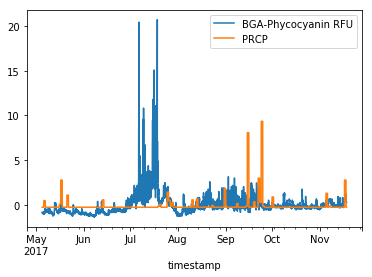

In [25]:
df[[target_column, 'PRCP']].plot.line()

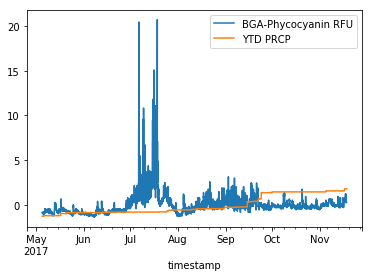

In [26]:
df[[target_column, 'YTD PRCP']].plot.line()

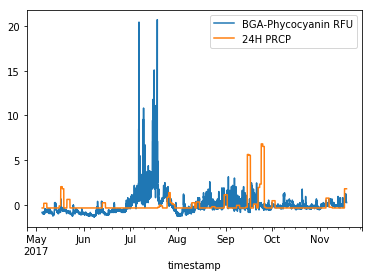

In [27]:
df[[target_column, '24H PRCP']].plot.line()

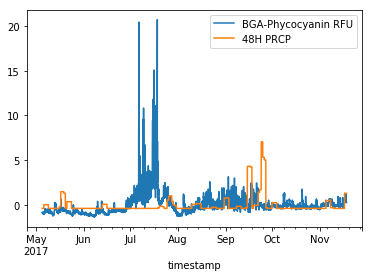

In [28]:
df[[target_column, '48H PRCP']].plot.line()

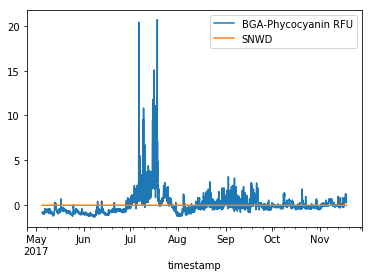

In [29]:
df[[target_column, 'SNWD']].plot.line()

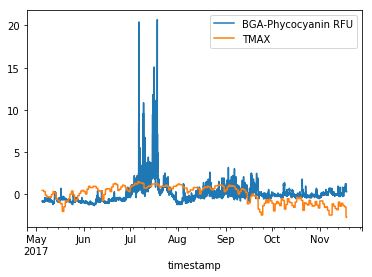

In [30]:
df[[target_column, 'TMAX']].plot.line()

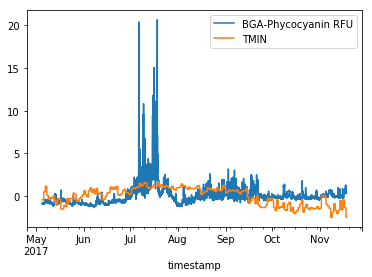

In [31]:
df[[target_column, 'TMIN']].plot.line()

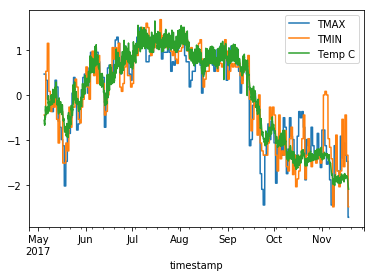

In [32]:
df[['TMAX', 'TMIN', 'Temp C']].plot.line()

As expected, we won't get any additional signal from air temperature measurements since they correlate to water temperature. And since the area has so little rain, rain will most likely not provide a decent signal either

## Extract Windows

In [33]:
presegmented_plot = pd.DataFrame(
    {'BGA RFU': train_dfs[train_index][target_column], 
     'Bloom Threshold': np.full(train_dfs[train_index].count()[0], RFU_THRESHOLD)})

In [34]:
def windowize(df, time_column):
    print("Segmenting...")
    x_windows, y_windows = hf.segment_dataset(df, time_column)
    print("Extracting feature windows...")
    x_windows = hf.extract_percentile(x_windows, time_column)
    print("Extracting target windows...")
    y_windows = hf.extract_percentile(y_windows, time_column)
    print("Combining extractions...")
    x_windows[target_column] = y_windows[target_column].values
    return x_windows

In [35]:
# Segment each data frame
for i in range(0, len(train_dfs)):
    print("Windowizing 2017 data set:", i)
    train_dfs[i] = windowize(train_dfs[i], 'datetime')
    print("Windowizing 2018 data set:", i)
    test_dfs[i] = windowize(test_dfs[i], 'datetime')
    print()

Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Windowizing 2017 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Windowizing 2017 data set: 2
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 2
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



## Add Weather Category

In [36]:
# Add a rainy category
for df in test_dfs + train_dfs:
    df['rainy'] = df['PRCP'].apply(
        lambda x: 1 if x > 0 else 0).astype('category')
test_dfs[test_index].columns

Index(['24H PRCP', '48H PRCP', 'BGA-Phycocyanin RFU', 'ODO (mg/L)', 'ODOSat%',
       'PRCP', 'SNOW', 'SNWD', 'Sp Cond (uS/cm)', 'TMAX', 'TMIN', 'Temp C',
       'Turbidity (NTU)', 'YTD PRCP', 'datetime', 'pH', 'pH (mV)', 'rainy'],
      dtype='object')

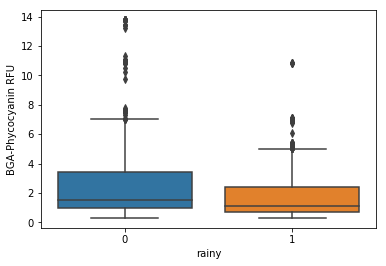

In [37]:
sns.boxplot(data=test_dfs[test_index], x='rainy', y=target_column)

In [38]:
# add the weather columns to our x_columns
x_columns = x_columns + ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', '24H PRCP', '48H PRCP', 'YTD PRCP', 'rainy']

## BGA RFU Levels

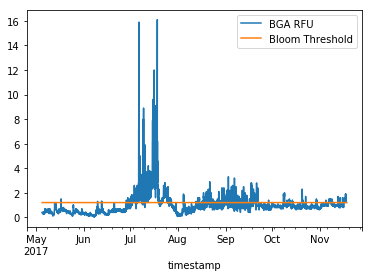

In [39]:
presegmented_plot.plot.line()

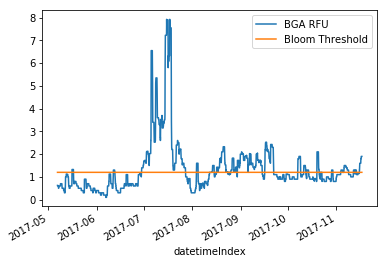

In [40]:
pd.DataFrame({'BGA RFU': train_dfs[train_index][target_column], 
            'Bloom Threshold': np.full(
                train_dfs[train_index].count()[0], RFU_THRESHOLD)}).plot.line()

In [41]:
lrf.add_target_column([train_dfs[train_index], test_dfs[test_index]], 
                      threshold=RFU_THRESHOLD)

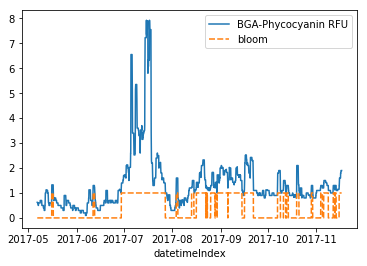

In [42]:
sns.lineplot(data=train_dfs[train_index][[target_column, 'bloom']], hue='bloom')

## Logistic Regression Model

### Null Model

In [43]:
# The null model's performance
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom', True)
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", train_dfs[train_index].columns)

Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]
columns: Index(['24H PRCP', '48H PRCP', 'BGA-Phycocyanin RFU', 'ODO (mg/L)', 'ODOSat%',
       'PRCP', 'SNOW', 'SNWD', 'Sp Cond (uS/cm)', 'TMAX', 'TMIN', 'Temp C',
       'Turbidity (NTU)', 'YTD PRCP', 'datetime', 'pH', 'pH (mV)', 'rainy',
       'bloom'],
      dtype='object')


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### All variables model

In [44]:
# All variables with testing on 2017 and training on 2018 model performance
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", x_columns)

Accuracy 0.7946261195584253
Recall: 0.8916008614501076
Precision 0.7840909090909091
Confusion Matrix:
 [[1331  684]
 [ 302 2484]]
columns: ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)', 'ODOSat%', 'ODO (mg/L)', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', '24H PRCP', '48H PRCP', 'YTD PRCP', 'rainy']


In [45]:
# All variables with training on 2018 and testing on 2017 model performance
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, test_dfs[test_index], train_dfs[train_index], x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", x_columns)

Accuracy 0.40385852090032154
Recall: 1.0
Precision 0.40385852090032154
Confusion Matrix:
 [[   0 2781]
 [   0 1884]]
columns: ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)', 'ODOSat%', 'ODO (mg/L)', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', '24H PRCP', '48H PRCP', 'YTD PRCP', 'rainy']


### Greedy Model

In [46]:
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
# Sort columns by accuracy
sorted_columns = lrf.sort_columns_by_metric(model, train_dfs[train_index], 
                                            test_dfs[test_index],
                                            x_columns,
                                            'bloom')

Training model with: Temp C
Accuracy 0.60612372422412
Recall: 0.416367552045944
Precision 0.8140350877192982
Confusion Matrix:
 [[1750  265]
 [1626 1160]]

Training model with: Sp Cond (uS/cm)


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]

Training model with: pH (mV)
Accuracy 0.5802957717142262
Recall: 1.0
Precision 0.5802957717142262
Confusion Matrix:
 [[   0 2015]
 [   0 2786]]

Training model with: pH
Accuracy 0.6854821912101645
Recall: 0.9178033022254127
Precision 0.6662324127149557
Confusion Matrix:
 [[ 734 1281]
 [ 229 2557]]

Training model with: Turbidity (NTU)


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]

Training model with: ODOSat%
Accuracy 0.7167256821495521
Recall: 0.6920315865039484
Precision 0.7934156378600823
Confusion Matrix:
 [[1513  502]
 [ 858 1928]]

Training model with: ODO (mg/L)
Accuracy 0.7042282857737971
Recall: 0.6826992103374013
Precision 0.7801476620180475
Confusion Matrix:
 [[1479  536]
 [ 884 1902]]

Training model with: PRCP


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]

Training model with: SNOW


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]

Training model with: SNWD


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]

Training model with: TMAX
Accuracy 0.5567590085398876
Recall: 0.42928930366116297
Precision 0.6897347174163783
Confusion Matrix:
 [[1477  538]
 [1590 1196]]

Training model with: TMIN
Accuracy 0.6702770256196626
Recall: 0.5337401292175161
Precision 0.8396386222473179
Confusion Matrix:
 [[1731  284]
 [1299 1487]]

Training model with: 24H PRCP


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]

Training model with: 48H PRCP


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]

Training model with: YTD PRCP


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]

Training model with: rainy
Accuracy 0.4197042282857738
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2015    0]
 [2786    0]]

ODOSat% metric value: 0.7167256821495521
ODO (mg/L) metric value: 0.7042282857737971
pH metric value: 0.6854821912101645
TMIN metric value: 0.6702770256196626
Temp C metric value: 0.60612372422412
pH (mV) metric value: 0.5802957717142262
TMAX metric value: 0.5567590085398876
Sp Cond (uS/cm) metric value: 0.4197042282857738
Turbidity (NTU) metric value: 0.4197042282857738
PRCP metric value: 0.4197042282857738
SNOW metric value: 0.4197042282857738
SNWD metric value: 0.4197042282857738
24H PRCP metric value: 0.4197042282857738
48H PRCP metric value: 0.4197042282857738
YTD PRCP metric value: 0.4197042282857738
rainy metric value: 0.4197042282857738


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [47]:
#create greedy model with training on 2017 testing on 2018 
model = SGDClassifier(max_iter=max_iter, loss=loss)

accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 
                                            'bloom', sorted_columns)
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


greedy_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'pH (mV)', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)', 'PRCP', 'SNOW', 'SNWD', '24H PRCP', '48H PRCP', 'YTD PRCP', 'rainy']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'pH (mV)', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)', 'PRCP', 'SNOW', 'SNWD', '24H PRCP', '48H PRCP', 'YTD PRCP', 'rainy']
Training model with: ['ODOSat%']
Test model accuracy: 0.7167256821495521
Test model recall: 0.6920315865039484
Test model precision: 0.7934156378600823

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.7523432618204541
Test model recall: 0.7552045944005743
Test model precision: 0.8058215243201838

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH']
Test model accuracy: 0.7546344511560091
Test model recall: 0.8908829863603733
Test model precision: 0.7395709177592372

Updating greedy model

Training model with: ['ODO

Model AUC: 0.8640


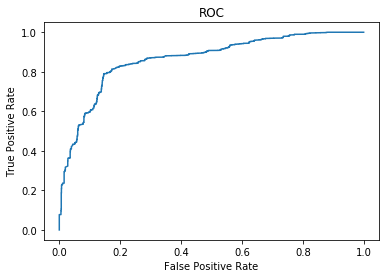

In [48]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test_dfs[test_index][['bloom']].values, predictions)

In [49]:
model = SGDClassifier(max_iter=max_iter, loss=loss)
# Sort columns by accuracy
sorted_columns = lrf.sort_columns_by_metric(model, test_dfs[test_index],
                                            train_dfs[train_index], 
                                            x_columns,
                                            'bloom')

Training model with: Temp C
Accuracy 0.5995712754555198
Recall: 0.7998938428874734
Precision 0.5026684456304202
Confusion Matrix:
 [[1290 1491]
 [ 377 1507]]

Training model with: Sp Cond (uS/cm)
Accuracy 0.5056806002143622
Recall: 0.5456475583864119
Precision 0.4148506860371267
Confusion Matrix:
 [[1331 1450]
 [ 856 1028]]

Training model with: pH (mV)


C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.5961414790996784
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2781    0]
 [1884    0]]

Training model with: pH
Accuracy 0.7035369774919614
Recall: 0.2898089171974522
Precision 0.9238578680203046
Confusion Matrix:
 [[2736   45]
 [1338  546]]

Training model with: Turbidity (NTU)
Accuracy 0.40385852090032154
Recall: 1.0
Precision 0.40385852090032154
Confusion Matrix:
 [[   0 2781]
 [   0 1884]]

Training model with: ODOSat%
Accuracy 0.8115755627009646
Recall: 0.7043524416135881
Precision 0.8047301394784718
Confusion Matrix:
 [[2459  322]
 [ 557 1327]]

Training model with: ODO (mg/L)
Accuracy 0.7457663451232583
Recall: 0.8152866242038217
Precision 0.6470092670598147
Confusion Matrix:
 [[1943  838]
 [ 348 1536]]

Training model with: PRCP
Accuracy 0.4162915326902465
Recall: 0.9798301486199575
Precision 0.40741558154932683
Confusion Matrix:
 [[  96 2685]
 [  38 1846]]

Training model with: SNOW
Accuracy 0.40385852090032154
Recall: 1.0
Precision 0.40385852090032154
Confusion M

C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.5961414790996784
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2781    0]
 [1884    0]]

Training model with: rainy
Accuracy 0.4478027867095391
Recall: 0.7038216560509554
Precision 0.3965311004784689
Confusion Matrix:
 [[ 763 2018]
 [ 558 1326]]

ODOSat% metric value: 0.8115755627009646
ODO (mg/L) metric value: 0.7457663451232583
pH metric value: 0.7035369774919614
TMIN metric value: 0.6034297963558414
Temp C metric value: 0.5995712754555198
pH (mV) metric value: 0.5961414790996784
YTD PRCP metric value: 0.5961414790996784
TMAX metric value: 0.5901393354769561
Sp Cond (uS/cm) metric value: 0.5056806002143622
rainy metric value: 0.4478027867095391
PRCP metric value: 0.4162915326902465
24H PRCP metric value: 0.4162915326902465
48H PRCP metric value: 0.4162915326902465
Turbidity (NTU) metric value: 0.40385852090032154
SNOW metric value: 0.40385852090032154
SNWD metric value: 0.40385852090032154


In [50]:
#create greedy model with training on 2018 testing on 2017 
model = SGDClassifier(max_iter=max_iter, loss=loss)

accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 
                                            'bloom', sorted_columns)
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


greedy_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'pH (mV)', 'YTD PRCP', 'TMAX', 'Sp Cond (uS/cm)', 'rainy', 'PRCP', '24H PRCP', '48H PRCP', 'Turbidity (NTU)', 'SNOW', 'SNWD']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'pH (mV)', 'YTD PRCP', 'TMAX', 'Sp Cond (uS/cm)', 'rainy', 'PRCP', '24H PRCP', '48H PRCP', 'Turbidity (NTU)', 'SNOW', 'SNWD']
Training model with: ['ODOSat%']
Test model accuracy: 0.7167256821495521
Test model recall: 0.6920315865039484
Test model precision: 0.7934156378600823

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.7523432618204541
Test model recall: 0.7552045944005743
Test model precision: 0.8058215243201838

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH']
Test model accuracy: 0.7546344511560091
Test model recall: 0.8908829863603733
Test model precision: 0.7395709177592372

Updating greedy model

Training model with: ['ODO

Model AUC: 0.8628


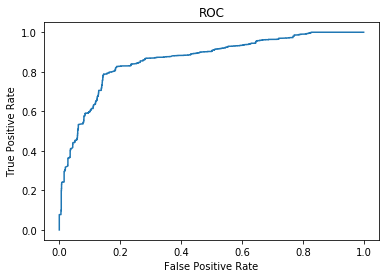

In [51]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test_dfs[test_index][['bloom']].values, predictions)

### Greedy Model with base columns

In [52]:
# with traing on 2017  testing on 2018 

accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 
    'bloom', sorted_columns, base_columns=['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 
                                           'Turbidity (NTU)', 'ODOSat%', 'ODO (mg/L)'])
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

greedy_columns: ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)', 'ODOSat%', 'ODO (mg/L)']
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'pH (mV)', 'YTD PRCP', 'TMAX', 'Sp Cond (uS/cm)', 'rainy', 'PRCP', '24H PRCP', '48H PRCP', 'Turbidity (NTU)', 'SNOW', 'SNWD']
adjusted sorted_columns: ['TMIN', 'YTD PRCP', 'TMAX', 'rainy', 'PRCP', '24H PRCP', '48H PRCP', 'SNOW', 'SNWD']
Training model with: ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)', 'ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.5875859196000833
Test model recall: 1.0
Test model precision: 0.5845572807385648

Training model with: ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)', 'ODOSat%', 'ODO (mg/L)', 'YTD PRCP']
Test model accuracy: 0.7985836284107478
Test model recall: 0.8291457286432161
Test model precision: 0.8247054623348804

Updating greedy model

Training model with: ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)', 'ODOSat%', 

Model AUC: 0.8716


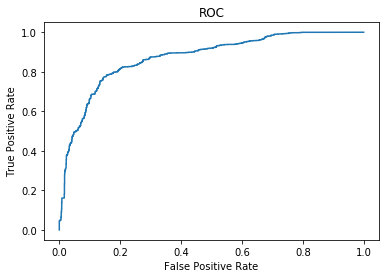

In [53]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test_dfs[test_index][['bloom']].values, predictions)

In [54]:
#with training on 2018 testing on 2017 
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, test_dfs[test_index],  train_dfs[train_index], x_columns, 
    'bloom', sorted_columns, base_columns=['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 
                                           'Turbidity (NTU)', 'ODOSat%', 'ODO (mg/L)'])
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

greedy_columns: ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)', 'ODOSat%', 'ODO (mg/L)']
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'pH (mV)', 'YTD PRCP', 'TMAX', 'Sp Cond (uS/cm)', 'rainy', 'PRCP', '24H PRCP', '48H PRCP', 'Turbidity (NTU)', 'SNOW', 'SNWD']
adjusted sorted_columns: ['TMIN', 'YTD PRCP', 'TMAX', 'rainy', 'PRCP', '24H PRCP', '48H PRCP', 'SNOW', 'SNWD']
Training model with: ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)', 'ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.6396570203644159
Test model recall: 0.9416135881104034
Test model precision: 0.5303437967115097

Training model with: ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)', 'ODOSat%', 'ODO (mg/L)', 'YTD PRCP']
Test model accuracy: 0.40385852090032154
Test model recall: 1.0
Test model precision: 0.40385852090032154

Training model with: ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)', 'ODOSat%', 'ODO (mg/L)', 'TMAX']

Model AUC: 0.8696


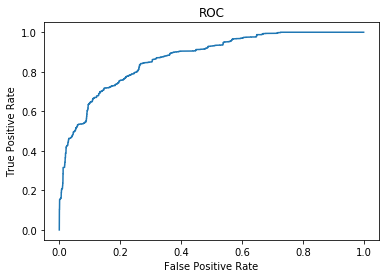

In [57]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(train_dfs[train_index][['bloom']].values, predictions)

## Random Forest Model

In [58]:
# All Inputs
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

Accuracy 0.608414913559675
Recall: 0.7925340990667624
Precision 0.629059829059829
Confusion Matrix:
 [[ 713 1302]
 [ 578 2208]]


In [59]:
# All Inputs with training on 2018 testing on 2017 
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.train_model(
    model,test_dfs[test_index], train_dfs[train_index],  x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

Accuracy 0.7037513397642015
Recall: 0.5313163481953291
Precision 0.6673333333333333
Confusion Matrix:
 [[2282  499]
 [ 883 1001]]


In [60]:
# Greedy Model
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom', sorted_columns)

C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


greedy_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'pH (mV)', 'YTD PRCP', 'TMAX', 'Sp Cond (uS/cm)', 'rainy', 'PRCP', '24H PRCP', '48H PRCP', 'Turbidity (NTU)', 'SNOW', 'SNWD']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'pH (mV)', 'YTD PRCP', 'TMAX', 'Sp Cond (uS/cm)', 'rainy', 'PRCP', '24H PRCP', '48H PRCP', 'Turbidity (NTU)', 'SNOW', 'SNWD']
Training model with: ['ODOSat%']
Test model accuracy: 0.6788169131430952
Test model recall: 0.6923905240488155
Test model precision: 0.7379495026778883

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.69693813788794
Test model recall: 0.7878679109834889
Test model precision: 0.7175547564563582

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH']
Test model accuracy: 0.6631951676734014
Test model recall: 0.6952620244077531
Test model precision: 0.7160813308687616

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMI

Model AUC: 0.7406


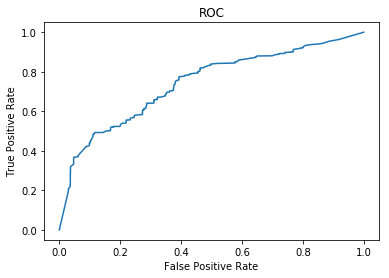

In [61]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test_dfs[test_index][['bloom']].values, predictions)

In [62]:
# Random Forest Greedy Model with training on 2018 testing on 2017 
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model,  test_dfs[test_index],train_dfs[train_index], x_columns, 'bloom', sorted_columns)

greedy_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'pH (mV)', 'YTD PRCP', 'TMAX', 'Sp Cond (uS/cm)', 'rainy', 'PRCP', '24H PRCP', '48H PRCP', 'Turbidity (NTU)', 'SNOW', 'SNWD']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'pH (mV)', 'YTD PRCP', 'TMAX', 'Sp Cond (uS/cm)', 'rainy', 'PRCP', '24H PRCP', '48H PRCP', 'Turbidity (NTU)', 'SNOW', 'SNWD']
Training model with: ['ODOSat%']
Test model accuracy: 0.6634512325830654
Test model recall: 0.611995753715499
Test model precision: 0.5788152610441767

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.7116827438370846
Test model recall: 0.6751592356687898
Test model precision: 0.6344139650872818

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH']
Test model accuracy: 0.6911039657020365
Test model recall: 0.3190021231422505
Test model precision: 0.7918313570487484

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TM

Model AUC: 0.8372


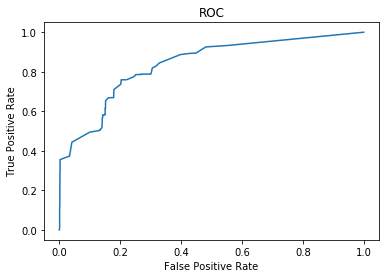

In [64]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(train_dfs[train_index][['bloom']].values, predictions)